# Arrival Diagnostics Before iLoc Filtering

The purpose of this notebook is to generate various diagnostic plots based on *ensemble.txt*, which is produced in Step 2 of the picking workflow and contains all arrivals from preexisting catalogues and automatically detected arrivals.

Valuable insights are also gained by comparing the travel-time residual distributions (for P- and S-arrival) and local ray-path coverage before/after iLoc filtering.

### Note: this notebook uses cartopy instead of basemap. Cartop is prefered over the deprecating Basemap.

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial import cKDTree
#from pykrige.uk import UniversalKriging
import shapefile
import matplotlib as mpl
import matplotlib.tri as tri
import os, sys 
import pandas
from collections import defaultdict
from tqdm import tqdm

sys.path.append("/g/data/ha3/fxz547/Githubz/hiperseis") # updated HiPerSeis code 

from seismic.pick_harvester.utils import CatalogCSV
from seismic.ASDFdatabase.FederatedASDFDataSet import FederatedASDFDataSet

from matplotlib import interactive
interactive(True)

%matplotlib inline

# Read Arrivals and Catalogue

In [2]:
# Path to output of step 2 in the picking workflow

PATH='/g/data/ha3/Passive/SHARED_DATA/Scratch/picking_workflow/step_2'
arrivals = pandas.read_csv(os.path.join(PATH,"ensemble.txt"), delim_whitespace=True) 

/g/data/ha3/Passive/Software/VENV/para_h5py/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# print columns
arrivals.columns

Index(['#eventID', 'originTimestamp', 'mag', 'originLon', 'originLat',
       'originDepthKm', 'net', 'sta', 'cha', 'pickTimestamp', 'phase',
       'stationLon', 'stationLat', 'az', 'baz', 'distance', 'ttResidual',
       'snr', 'qualityMeasureCWT', 'domFreq', 'qualityMeasureSlope',
       'bandIndex', 'nSigma'],
      dtype='object')

In [4]:
# Read catalogue
# cat = CatalogCSV('/g/data/ha3/la8536/Test/Data/')

cat = CatalogCSV('/g/data/ha3/Passive/Events/Unified/')

Reading /g/data/ha3/Passive/Events/Unified/CATGG.csv


# Plot Events Catalogue

Text(0, 0.5, 'Frequency')

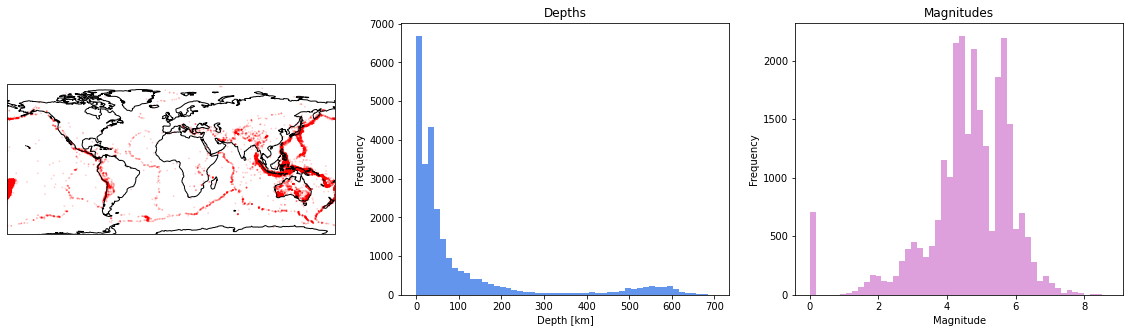

In [5]:
events = cat.get_events()

import cartopy.crs as ccrs 

maglist = []
depthlist = []
elonlat = []
for e in events:
    maglist.append(e.preferred_magnitude.magnitude_value)
    elonlat.append([e.preferred_origin.lon, e.preferred_origin.lat])
    depthlist.append(e.preferred_origin.depthkm)
# end for

maglist = np.array(maglist)
elonlat = np.array(elonlat)
depthlist = np.array(depthlist)

fig=plt.figure()
fig.set_size_inches(20,5)

ax1 = fig.add_subplot(1,3,1, projection=ccrs.PlateCarree())

ax1.coastlines()

px = elonlat[:,0]
py = elonlat[:,1]
ax1.scatter(px, py, 3, c='red', edgecolor='none', alpha=0.2)
ax1.set_xlabel('Event locations')

ax2 = fig.add_subplot(1,3,2)
ax2.hist(depthlist, bins=50, fc='cornflowerblue', ec='none')
ax2.set_title('Depths')
ax2.set_xlabel('Depth [km]')
ax2.set_ylabel('Frequency')

ax3 = fig.add_subplot(1,3,3)
ax3.hist(maglist, bins=50, fc='plum', ec='none')
ax3.set_title('Magnitudes')
ax3.set_xlabel('Magnitude')
ax3.set_ylabel('Frequency')


# Plot Travel-time Residuals


Text(0.5, 0, 'Travel-time residual [s]')

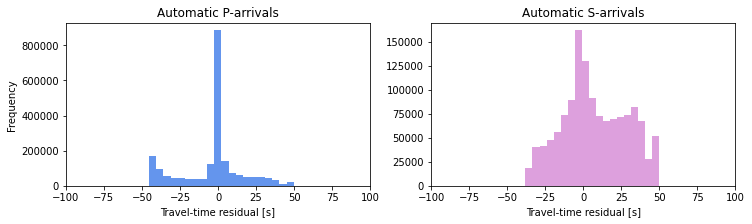

In [6]:
# plot histograms for automatically detected p and s arrivals 
# Note that automatically detected arrivals are identified by columns e.g. 'snr', 'nsigma', etc. 
# with a positive value

fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,3)

auto_p = arrivals['ttResidual'][(arrivals['snr']>0) & (arrivals['phase'] == 'P')]
auto_s = arrivals['ttResidual'][(arrivals['snr']>0) & (arrivals['phase'] == 'S')]

axes[0].hist(auto_p, fc='cornflowerblue', ec='none', bins=20)
axes[0].set_xlim(-100,100)
axes[0].set_title('Automatic P-arrivals')
axes[0].set_xlabel('Travel-time residual [s]')
axes[0].set_ylabel('Frequency')

axes[1].hist(auto_s, fc='plum', ec='none', bins=20)
axes[1].set_xlim(-100,100)
axes[1].set_title('Automatic S-arrivals')
axes[1].set_xlabel('Travel-time residual [s]')


# Events in the Australasian Region

/g/data/ha3/Passive/Software/VENV/para_h5py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'latlon'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


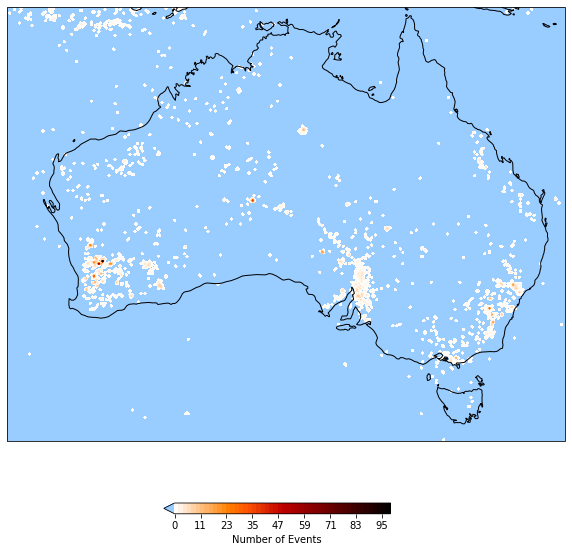

In [7]:
# Generate event concentration on a 0.1x0.1 deg grid

from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

# define 0.1x0.1 deg grid
au_sx, au_ex, dx = 110, 155, 0.1 # Australasian region (lon bounds)
au_sy, au_ey, dy = -45, -10, 0.1 # Australasian region (lat bounds)

nx = np.int_(np.ceil((au_ex-au_sx)/dx))+1
ny = np.int_(np.ceil((au_ey-au_sy)/dy))+1
res = int(1/float(dx)) # per deg

gx, gy = np.meshgrid(np.linspace(au_sx, au_ex, nx), np.linspace(au_sy, au_ey, ny), indexing='ij')
ge = np.zeros(gx.shape)

for e in events:
    elon, elat, etime = e.preferred_origin.lon, e.preferred_origin.lat, e.preferred_origin.utctime.timestamp
    if(elon<au_sx or elon>au_ex or elat<au_sy or elat>au_ey): continue
    exi = np.int_((elon - au_sx)/dx)
    eyi = np.int_((elat - au_sy)/dy)

    ge[exi, eyi] += 1        
# end for

# Plot results
fig = plt.figure()
fig.set_size_inches(10,10)
cax = fig.add_axes([0.1,0.1,0.8,0.1])
cax.set_visible(False)

llcrnrlat=-45
urcrnrlat=-10
llcrnrlon=110
urcrnrlon=155

ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())
ax1.coastlines()

cbi=ax1.contourf(gx, gy, ge, cmap='gist_heat_r', latlon=True, 
               levels=np.linspace(0, np.max(ge), 51), extend='min')
cbi.cmap.set_under('#99ccff')


cbar = fig.colorbar(cbi, ax=cax, format='%d', extend='min', orientation='horizontal')
cbar.set_label('Number of Events')

# Local Raypath (<10 deg) Coverage in the Australasian Region

In [8]:
# Apply spatial clip and use only P+Pg and S+Sg arrivals

gzp = np.zeros(gx.shape)
gzs = np.zeros(gx.shape)

local_distance = 10 # deg

au_arrivals = arrivals[(arrivals['originLon']>au_sx) & (arrivals['originLon']<au_ex) & 
                       (arrivals['originLat']>au_sy) & (arrivals['originLat']<au_ey) &
                       (arrivals['stationLon']>au_sx) & (arrivals['stationLon']<au_ex) & 
                       (arrivals['stationLat']>au_sy) & (arrivals['stationLat']<au_ey) &
                       (arrivals['distance']<local_distance)]

au_arrivals_p = au_arrivals[(au_arrivals['phase']=='P') | (au_arrivals['phase']=='Pg')]
au_arrivals_s = au_arrivals[(au_arrivals['phase']=='S') | (au_arrivals['phase']=='Sg')]

print ('#P-arrivals: %d, #S-arrivals: %d'%(len(au_arrivals_p), len(au_arrivals_s)))

#P-arrivals: 79308, #S-arrivals: 55758


In [9]:
# Generate surface-projected local (<=10 deg) ray-path coverage for P- and S-arrivals
# on a 0.1x0.1 deg grid within the Australasian region.

geod = Geodesic.WGS84

peset = set()
psset = set()

for i in tqdm(np.arange(len(au_arrivals_p))):
    elon, elat, slon, slat = au_arrivals_p['originLon'].iloc[i], au_arrivals_p['originLat'].iloc[i], \
                             au_arrivals_p['stationLon'].iloc[i], au_arrivals_p['stationLat'].iloc[i]
    
    peset.add((elon, elat))
    psset.add((slon, slat))
    
    g = geod.Inverse(elat, elon, slat, slon)
    l = geod.Line(g['lat1'], g['lon1'], g['azi1'])
    num = int(np.ceil(g['a12']*res))

    for j in range(num+1):
        pos = l.ArcPosition(j * g['a12'] / num)
        cy, cx = pos['lat2'], pos['lon2']
    
        cxi = np.int_((cx - au_sx)/dx)
        cyi = np.int_((cy - au_sy)/dy)
        
        gzp[cxi, cyi] += 1        
    # end for
# end for    

print ('P-arrivals: Unique #events (%d), Unique #stations (%d)'%(len(peset), len(psset)))

seset = set()
ssset = set()
for i in tqdm(np.arange(len(au_arrivals_s))):
    elon, elat, slon, slat = au_arrivals_s['originLon'].iloc[i], au_arrivals_s['originLat'].iloc[i], \
                             au_arrivals_s['stationLon'].iloc[i], au_arrivals_s['stationLat'].iloc[i]
    
    seset.add((elon, elat))
    ssset.add((slon, slat))
    
    g = geod.Inverse(elat, elon, slat, slon)
    l = geod.Line(g['lat1'], g['lon1'], g['azi1'])
    num = int(np.ceil(g['a12']*res))

    for j in range(num+1):
        pos = l.ArcPosition(j * g['a12'] / num)
        cy, cx = pos['lat2'], pos['lon2']
    
        cxi = np.int_((cx - au_sx)/dx)
        cyi = np.int_((cy - au_sy)/dy)
        
        gzs[cxi, cyi] += 1        
    # end for
# end for   

print ('S-arrivals: Unique #events (%d), Unique #stations (%d)'%(len(seset), len(ssset)))

  0%|          | 65/55758 [00:00<01:25, 649.79it/s]

P-arrivals: Unique #events (3311), Unique #stations (657)


100%|██████████| 55758/55758 [01:40<00:00, 555.62it/s]

S-arrivals: Unique #events (3262), Unique #stations (642)


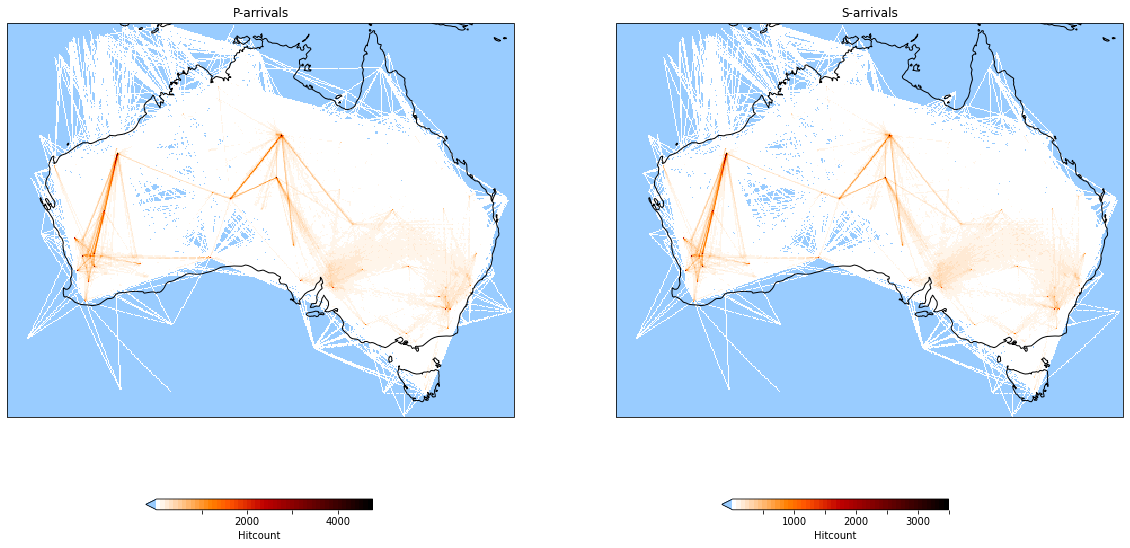

In [10]:
# Plot coverage

import matplotlib.tri as tri
from matplotlib import colors

# Plot p-coverage
fig=plt.figure()

fig.set_size_inches(20,10)
cax1 = fig.add_axes([0.1,0.1,0.4,0.1])
cax2 = fig.add_axes([0.5,0.1,0.4,0.1])
cax1.set_visible(False)
cax2.set_visible(False)

llcrnrlat=-45
urcrnrlat=-10
llcrnrlon=110
urcrnrlon=155

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())
ax1.coastlines()

cbi=ax1.pcolormesh(gx, gy, gzp, vmin=1, vmax=np.max(gzp), cmap=plt.get_cmap('gist_heat_r', 50))

cbi.cmap.set_under('#99ccff')
cbar = fig.colorbar(cbi, ax=cax1, format='%d', extend='min',
                    orientation='horizontal')
cbar.set_label("Hitcount")
ax1.set_title('P-arrivals')
for label in cbar.ax.get_xticklabels()[::2]:
    label.set_visible(False)

# Plot s-coverage
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())
ax2.coastlines()

cbi=ax2.pcolormesh(gx, gy, gzs, vmin=1, vmax=np.max(gzs), cmap=plt.get_cmap('gist_heat_r', 50))

cbi.cmap.set_under('#99ccff')
cbar = fig.colorbar(cbi, ax=cax2, format='%d', extend='min',
                    orientation='horizontal')
cbar.set_label("Hitcount")
ax2.set_title('S-arrivals')
for label in cbar.ax.get_xticklabels()[::2]:
    label.set_visible(False)
    